# **Fashion Images Generation Using GAN**

We will implement GAN to generate images similar to the Fashion-MNIST dataset using TensorFlow and Keras.

**Import Libraries**

In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

**Load Fashion-MNIST Dataset**

We will load the features of the training data. Then, we will divide each pixel value by 127.5 and subtract it from 1 to obtain pixel values range between -1 and 1.

In [2]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


**Define Function To Generate Latent Points**

In [3]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

**Define Function To Generate Real Samples**

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

**Define Function To Generate Fake Samples**

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

**Define Function To Summarize The Performance**

This function will summarize the performance by generating a fake sample and plotting it, followed by saving the model.

In [6]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

**Define Function To Plot Generated Images**

In [7]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

**Build Discriminator Model**

We will use a couple of Dense, Flatten and Dropout layers with leaky relu as an activation function in hidden layers and sigmoid in the final layer, adam as an optimizer and binary cross-entropy as a loss function.

In [10]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = define_discriminator()

**Build Generator Model**

We will use a couple of Dense layers to define the generator model with leaky relu as an activation function in hidden layers and tanh in the final layer. The shape of generated images 28x28x1.

In [11]:
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

generator = define_generator(100)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


**Build And Compile The Combined Model**

We will use adam as an optimizer and binary cross-entropy as a loss function.

In [12]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

gan_model = define_gan(generator, discriminator)

**Train Generator And Discriminator**

To train the Discriminator, we will first generates real samples, updates the discriminator’s weights, generates fake samples, and then updates the discriminator’s weights again. And to train the Generator, we will first generates latent points, generates labels as 1 to fool the discriminator, and then updates the generator’s weights.

In [14]:
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

Call the train function using 100 random samples, 20 epochs, and a batch size of 64.

2/2 [==============================] - 0s 9ms/step
>1, dr[0.618,0.734], df[0.940,0.359], g[1.390,0.219]
2/2 [==============================] - 0s 9ms/step
>2, dr[0.612,0.719], df[0.585,0.594], g[1.976,0.078]
2/2 [==============================] - 0s 10ms/step
>3, dr[0.851,0.422], df[0.364,0.844], g[2.107,0.062]
2/2 [==============================] - 0s 10ms/step
>4, dr[0.870,0.469], df[0.630,0.562], g[2.006,0.062]
2/2 [==============================] - 0s 10ms/step
>5, dr[0.722,0.531], df[0.479,0.750], g[1.779,0.078]
2/2 [==============================] - 0s 14ms/step
>6, dr[0.800,0.484], df[0.510,0.719], g[1.865,0.078]
2/2 [==============================] - 0s 11ms/step
>7, dr[0.816,0.484], df[0.539,0.703], g[2.050,0.031]
2/2 [==============================] - 0s 10ms/step
>8, dr[0.766,0.547], df[0.416,0.844], g[1.908,0.062]
2/2 [==============================] - 0s 11ms/step
>9, dr[0.821,0.422], df[0.603,0.688], g[2.312,0.062]
2/2 [==============================] - 0s 12ms/step
>10, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: model_0937.h5
2/2 [==============================] - 0s 11ms/step
>938, dr[0.594,0.766], df[0.593,0.672], g[2.588,0.078]
2/2 [==============================] - 0s 11ms/step
>939, dr[0.409,0.750], df[0.637,0.562], g[1.459,0.219]
2/2 [==============================] - 0s 13ms/step
>940, dr[0.491,0.828], df[0.523,0.641], g[2.365,0.062]
2/2 [==============================] - 0s 11ms/step
>941, dr[0.252,0.969], df[0.714,0.500], g[1.460,0.250]
2/2 [==============================] - 0s 12ms/step
>942, dr[0.374,0.828], df[0.542,0.656], g[1.995,0.141]
2/2 [==============================] - 0s 11ms/step
>943, dr[0.428,0.891], df[0.632,0.672], g[1.375,0.188]
2/2 [==============================] - 0s 9ms/step
>944, dr[0.528,0.766], df[0.522,0.719], g[2.347,0.078]
2/2 [==============================] - 0s 10ms/step
>945, dr[0.361,0.906], df[0.449,0.781], g[2.127,0.125]
2/2 [==============================] - 0s 10ms/step
>946, dr[0.297,0.922], df[0.524,0.688], g[2.812,0.062]
2/2 [===========

>Saved: model_1874.h5
2/2 [==============================] - 0s 15ms/step
>1875, dr[0.408,0.781], df[0.505,0.797], g[1.905,0.047]
2/2 [==============================] - 0s 11ms/step
>1876, dr[0.622,0.594], df[0.544,0.750], g[1.841,0.047]
2/2 [==============================] - 0s 11ms/step
>1877, dr[0.497,0.750], df[0.506,0.844], g[1.722,0.078]
2/2 [==============================] - 0s 11ms/step
>1878, dr[0.438,0.797], df[0.535,0.844], g[1.604,0.047]
2/2 [==============================] - 0s 10ms/step
>1879, dr[0.493,0.688], df[0.476,0.812], g[1.520,0.141]
2/2 [==============================] - 0s 10ms/step
>1880, dr[0.369,0.797], df[0.387,0.891], g[1.699,0.109]
2/2 [==============================] - 0s 14ms/step
>1881, dr[0.447,0.734], df[0.564,0.781], g[1.683,0.062]
2/2 [==============================] - 0s 12ms/step
>1882, dr[0.446,0.750], df[0.451,0.875], g[1.912,0.016]
2/2 [==============================] - 0s 20ms/step
>1883, dr[0.429,0.734], df[0.398,0.875], g[1.689,0.078]
2/2 [=

>Saved: model_2811.h5
2/2 [==============================] - 0s 11ms/step
>2812, dr[0.649,0.609], df[0.455,0.828], g[1.570,0.109]
2/2 [==============================] - 0s 14ms/step
>2813, dr[0.357,0.812], df[0.457,0.922], g[2.000,0.062]
2/2 [==============================] - 0s 11ms/step
>2814, dr[0.572,0.656], df[0.488,0.797], g[1.893,0.094]
2/2 [==============================] - 0s 15ms/step
>2815, dr[0.534,0.703], df[0.521,0.797], g[1.684,0.109]
2/2 [==============================] - 0s 13ms/step
>2816, dr[0.499,0.688], df[0.499,0.812], g[1.711,0.062]
2/2 [==============================] - 0s 14ms/step
>2817, dr[0.486,0.719], df[0.501,0.750], g[1.514,0.062]
2/2 [==============================] - 0s 13ms/step
>2818, dr[0.491,0.719], df[0.421,0.828], g[1.802,0.047]
2/2 [==============================] - 0s 11ms/step
>2819, dr[0.453,0.703], df[0.441,0.875], g[1.911,0.062]
2/2 [==============================] - 0s 10ms/step
>2820, dr[0.553,0.703], df[0.536,0.781], g[1.539,0.141]
2/2 [=

>Saved: model_3748.h5
2/2 [==============================] - 0s 10ms/step
>3749, dr[0.479,0.719], df[0.533,0.750], g[1.474,0.094]
2/2 [==============================] - 0s 20ms/step
>3750, dr[0.411,0.797], df[0.484,0.797], g[1.675,0.094]
2/2 [==============================] - 0s 22ms/step
>3751, dr[0.451,0.750], df[0.633,0.750], g[1.781,0.078]
2/2 [==============================] - 0s 18ms/step
>3752, dr[0.646,0.578], df[0.607,0.812], g[1.853,0.125]
2/2 [==============================] - 0s 10ms/step
>3753, dr[0.652,0.672], df[0.481,0.766], g[1.366,0.156]
2/2 [==============================] - 0s 14ms/step
>3754, dr[0.522,0.672], df[0.535,0.750], g[1.489,0.125]
2/2 [==============================] - 0s 11ms/step
>3755, dr[0.643,0.672], df[0.523,0.766], g[1.770,0.078]
2/2 [==============================] - 0s 20ms/step
>3756, dr[0.461,0.797], df[0.488,0.844], g[1.809,0.078]
2/2 [==============================] - 0s 15ms/step
>3757, dr[0.487,0.750], df[0.560,0.734], g[1.739,0.094]
2/2 [=

>Saved: model_4685.h5
2/2 [==============================] - 0s 10ms/step
>4686, dr[0.648,0.625], df[0.486,0.812], g[2.032,0.031]
2/2 [==============================] - 0s 11ms/step
>4687, dr[0.663,0.625], df[0.563,0.812], g[1.464,0.078]
2/2 [==============================] - 0s 12ms/step
>4688, dr[0.533,0.688], df[0.608,0.734], g[1.661,0.047]
2/2 [==============================] - 0s 11ms/step
>4689, dr[0.628,0.594], df[0.505,0.812], g[1.668,0.062]
2/2 [==============================] - 0s 11ms/step
>4690, dr[0.614,0.609], df[0.623,0.703], g[1.491,0.094]
2/2 [==============================] - 0s 13ms/step
>4691, dr[0.577,0.594], df[0.400,0.891], g[1.289,0.172]
2/2 [==============================] - 0s 13ms/step
>4692, dr[0.554,0.703], df[0.552,0.797], g[1.422,0.172]
2/2 [==============================] - 0s 11ms/step
>4693, dr[0.543,0.688], df[0.668,0.734], g[1.289,0.188]
2/2 [==============================] - 0s 17ms/step
>4694, dr[0.585,0.641], df[0.519,0.781], g[1.537,0.141]
2/2 [=

>Saved: model_5622.h5
2/2 [==============================] - 0s 21ms/step
>5623, dr[0.628,0.609], df[0.541,0.828], g[1.432,0.172]
2/2 [==============================] - 0s 14ms/step
>5624, dr[0.589,0.672], df[0.542,0.734], g[1.474,0.141]
2/2 [==============================] - 0s 14ms/step
>5625, dr[0.543,0.672], df[0.526,0.766], g[1.412,0.156]
2/2 [==============================] - 0s 23ms/step
>5626, dr[0.611,0.625], df[0.550,0.734], g[1.571,0.188]
2/2 [==============================] - 0s 19ms/step
>5627, dr[0.655,0.578], df[0.670,0.688], g[1.453,0.125]
2/2 [==============================] - 0s 21ms/step
>5628, dr[0.559,0.625], df[0.516,0.812], g[1.478,0.062]
2/2 [==============================] - 0s 19ms/step
>5629, dr[0.594,0.656], df[0.640,0.766], g[1.484,0.031]
2/2 [==============================] - 0s 17ms/step
>5630, dr[0.596,0.578], df[0.485,0.828], g[1.364,0.156]
2/2 [==============================] - 0s 15ms/step
>5631, dr[0.484,0.719], df[0.413,0.828], g[1.557,0.219]
2/2 [=

>Saved: model_6559.h5
2/2 [==============================] - 0s 17ms/step
>6560, dr[0.775,0.547], df[0.602,0.766], g[1.365,0.062]
2/2 [==============================] - 0s 25ms/step
>6561, dr[0.533,0.688], df[0.466,0.922], g[1.307,0.062]
2/2 [==============================] - 0s 14ms/step
>6562, dr[0.512,0.672], df[0.536,0.797], g[1.396,0.156]
2/2 [==============================] - 0s 15ms/step
>6563, dr[0.601,0.594], df[0.724,0.641], g[1.243,0.125]
2/2 [==============================] - 0s 13ms/step
>6564, dr[0.508,0.688], df[0.622,0.766], g[1.461,0.109]
2/2 [==============================] - 0s 13ms/step
>6565, dr[0.669,0.594], df[0.818,0.719], g[1.189,0.188]
2/2 [==============================] - 0s 12ms/step
>6566, dr[0.500,0.703], df[0.487,0.828], g[1.580,0.094]
2/2 [==============================] - 0s 11ms/step
>6567, dr[0.727,0.703], df[0.610,0.703], g[1.303,0.078]
2/2 [==============================] - 0s 12ms/step
>6568, dr[0.476,0.781], df[0.543,0.797], g[1.471,0.031]
2/2 [=

>Saved: model_7496.h5
2/2 [==============================] - 0s 13ms/step
>7497, dr[0.741,0.625], df[0.523,0.828], g[1.333,0.219]
2/2 [==============================] - 0s 12ms/step
>7498, dr[0.395,0.859], df[0.513,0.812], g[2.718,0.078]
2/2 [==============================] - 0s 14ms/step
>7499, dr[0.595,0.625], df[0.527,0.766], g[1.447,0.094]
2/2 [==============================] - 0s 16ms/step
>7500, dr[0.464,0.688], df[0.709,0.703], g[2.296,0.031]
2/2 [==============================] - 0s 18ms/step
>7501, dr[0.420,0.781], df[0.337,0.906], g[2.183,0.094]
2/2 [==============================] - 0s 10ms/step
>7502, dr[0.572,0.734], df[0.651,0.844], g[1.974,0.062]
2/2 [==============================] - 0s 10ms/step
>7503, dr[0.595,0.719], df[0.577,0.766], g[1.473,0.094]
2/2 [==============================] - 0s 11ms/step
>7504, dr[0.550,0.656], df[0.571,0.750], g[1.366,0.109]
2/2 [==============================] - 0s 11ms/step
>7505, dr[0.576,0.703], df[0.523,0.828], g[1.562,0.031]
2/2 [=

>Saved: model_8433.h5
2/2 [==============================] - 0s 16ms/step
>8434, dr[0.677,0.641], df[0.597,0.672], g[1.556,0.125]
2/2 [==============================] - 0s 28ms/step
>8435, dr[0.576,0.672], df[0.576,0.688], g[1.235,0.172]
2/2 [==============================] - 0s 16ms/step
>8436, dr[0.546,0.703], df[0.675,0.625], g[1.320,0.109]
2/2 [==============================] - 0s 18ms/step
>8437, dr[0.448,0.750], df[0.401,0.906], g[1.760,0.078]
2/2 [==============================] - 0s 14ms/step
>8438, dr[0.737,0.516], df[0.436,0.828], g[1.376,0.078]
2/2 [==============================] - 0s 19ms/step
>8439, dr[0.541,0.656], df[0.610,0.781], g[1.436,0.109]
2/2 [==============================] - 0s 12ms/step
>8440, dr[0.557,0.672], df[0.761,0.688], g[1.612,0.172]
2/2 [==============================] - 0s 11ms/step
>8441, dr[0.651,0.641], df[0.609,0.797], g[1.498,0.141]
2/2 [==============================] - 0s 12ms/step
>8442, dr[0.616,0.625], df[0.549,0.781], g[1.240,0.078]
2/2 [=

>Saved: model_9370.h5
2/2 [==============================] - 0s 16ms/step
>9371, dr[0.513,0.656], df[0.562,0.750], g[1.655,0.078]
2/2 [==============================] - 0s 11ms/step
>9372, dr[0.566,0.656], df[0.447,0.828], g[1.736,0.094]
2/2 [==============================] - 0s 10ms/step
>9373, dr[0.532,0.703], df[0.566,0.750], g[1.742,0.078]
2/2 [==============================] - 0s 12ms/step
>9374, dr[0.589,0.656], df[0.610,0.688], g[1.717,0.078]
2/2 [==============================] - 0s 12ms/step
>9375, dr[0.528,0.734], df[0.629,0.766], g[1.647,0.062]
2/2 [==============================] - 0s 11ms/step
>9376, dr[0.502,0.703], df[0.431,0.844], g[1.667,0.078]
2/2 [==============================] - 0s 13ms/step
>9377, dr[0.617,0.656], df[0.641,0.766], g[1.427,0.125]
2/2 [==============================] - 0s 13ms/step
>9378, dr[0.463,0.750], df[0.535,0.797], g[1.582,0.078]
2/2 [==============================] - 0s 11ms/step
>9379, dr[0.640,0.578], df[0.552,0.766], g[1.652,0.109]
2/2 [=

>Saved: model_10307.h5
2/2 [==============================] - 0s 11ms/step
>10308, dr[0.463,0.734], df[0.433,0.781], g[2.024,0.109]
2/2 [==============================] - 0s 12ms/step
>10309, dr[0.572,0.641], df[0.558,0.734], g[1.419,0.141]
2/2 [==============================] - 0s 12ms/step
>10310, dr[0.571,0.688], df[0.582,0.734], g[1.447,0.109]
2/2 [==============================] - 0s 11ms/step
>10311, dr[0.574,0.719], df[0.704,0.625], g[1.516,0.078]
2/2 [==============================] - 0s 10ms/step
>10312, dr[0.551,0.703], df[0.496,0.828], g[1.414,0.156]
2/2 [==============================] - 0s 13ms/step
>10313, dr[0.490,0.766], df[0.565,0.734], g[1.649,0.141]
2/2 [==============================] - 0s 12ms/step
>10314, dr[0.537,0.781], df[0.536,0.781], g[1.786,0.094]
2/2 [==============================] - 0s 13ms/step
>10315, dr[0.509,0.672], df[0.489,0.734], g[1.706,0.062]
2/2 [==============================] - 0s 13ms/step
>10316, dr[0.676,0.609], df[0.478,0.812], g[2.001,0.0

>Saved: model_11244.h5
2/2 [==============================] - 0s 14ms/step
>11245, dr[0.566,0.641], df[0.565,0.734], g[1.519,0.016]
2/2 [==============================] - 0s 22ms/step
>11246, dr[0.539,0.703], df[0.652,0.734], g[1.438,0.125]
2/2 [==============================] - 0s 25ms/step
>11247, dr[0.837,0.406], df[0.652,0.781], g[1.308,0.141]
2/2 [==============================] - 0s 11ms/step
>11248, dr[0.469,0.703], df[0.530,0.828], g[1.585,0.125]
2/2 [==============================] - 0s 22ms/step
>11249, dr[0.769,0.438], df[0.497,0.734], g[1.297,0.219]
2/2 [==============================] - 0s 17ms/step
>11250, dr[0.586,0.688], df[0.697,0.625], g[1.654,0.094]
2/2 [==============================] - 0s 11ms/step
>11251, dr[0.614,0.656], df[0.632,0.750], g[1.413,0.156]
2/2 [==============================] - 0s 10ms/step
>11252, dr[0.610,0.594], df[0.453,0.812], g[1.537,0.016]
2/2 [==============================] - 0s 12ms/step
>11253, dr[0.646,0.578], df[0.560,0.750], g[1.393,0.1

>Saved: model_12181.h5
2/2 [==============================] - 0s 12ms/step
>12182, dr[0.760,0.578], df[0.609,0.734], g[1.609,0.109]
2/2 [==============================] - 0s 13ms/step
>12183, dr[0.497,0.766], df[0.613,0.766], g[1.478,0.188]
2/2 [==============================] - 0s 15ms/step
>12184, dr[0.580,0.641], df[0.465,0.859], g[1.596,0.109]
2/2 [==============================] - 0s 13ms/step
>12185, dr[0.558,0.688], df[0.640,0.703], g[1.477,0.125]
2/2 [==============================] - 0s 11ms/step
>12186, dr[0.505,0.656], df[0.677,0.672], g[1.645,0.141]
2/2 [==============================] - 0s 12ms/step
>12187, dr[0.624,0.656], df[0.448,0.812], g[1.628,0.078]
2/2 [==============================] - 0s 11ms/step
>12188, dr[0.641,0.594], df[0.654,0.672], g[1.396,0.094]
2/2 [==============================] - 0s 10ms/step
>12189, dr[0.550,0.609], df[0.384,0.891], g[1.737,0.078]
2/2 [==============================] - 0s 12ms/step
>12190, dr[0.677,0.594], df[0.524,0.797], g[1.386,0.1

>Saved: model_13118.h5
2/2 [==============================] - 0s 16ms/step
>13119, dr[0.634,0.625], df[0.533,0.719], g[1.567,0.141]
2/2 [==============================] - 0s 13ms/step
>13120, dr[0.569,0.750], df[0.545,0.734], g[1.384,0.062]
2/2 [==============================] - 0s 10ms/step
>13121, dr[0.487,0.688], df[0.485,0.875], g[1.562,0.109]
2/2 [==============================] - 0s 13ms/step
>13122, dr[0.585,0.672], df[0.677,0.703], g[1.665,0.125]
2/2 [==============================] - 0s 10ms/step
>13123, dr[0.596,0.688], df[0.448,0.812], g[1.572,0.109]
2/2 [==============================] - 0s 11ms/step
>13124, dr[0.515,0.734], df[0.538,0.734], g[1.549,0.109]
2/2 [==============================] - 0s 12ms/step
>13125, dr[0.623,0.609], df[0.541,0.750], g[1.621,0.141]
2/2 [==============================] - 0s 13ms/step
>13126, dr[0.737,0.516], df[0.717,0.703], g[1.282,0.141]
2/2 [==============================] - 0s 10ms/step
>13127, dr[0.558,0.641], df[0.560,0.734], g[1.357,0.1

>Saved: model_14055.h5
2/2 [==============================] - 0s 12ms/step
>14056, dr[0.506,0.641], df[0.448,0.844], g[1.627,0.125]
2/2 [==============================] - 0s 15ms/step
>14057, dr[0.468,0.750], df[0.548,0.797], g[1.547,0.172]
2/2 [==============================] - 0s 9ms/step
>14058, dr[0.567,0.625], df[0.661,0.688], g[1.634,0.062]
2/2 [==============================] - 0s 11ms/step
>14059, dr[0.652,0.594], df[0.483,0.828], g[1.524,0.047]
2/2 [==============================] - 0s 11ms/step
>14060, dr[0.465,0.734], df[0.676,0.688], g[1.540,0.125]
2/2 [==============================] - 0s 11ms/step
>14061, dr[0.655,0.594], df[0.579,0.688], g[1.637,0.109]
2/2 [==============================] - 0s 11ms/step
>14062, dr[0.560,0.703], df[0.383,0.859], g[1.832,0.109]
2/2 [==============================] - 0s 11ms/step
>14063, dr[0.638,0.625], df[0.464,0.766], g[1.487,0.203]
2/2 [==============================] - 0s 11ms/step
>14064, dr[0.487,0.688], df[0.803,0.641], g[1.923,0.01

>Saved: model_14992.h5
2/2 [==============================] - 0s 14ms/step
>14993, dr[0.582,0.656], df[0.707,0.641], g[1.185,0.156]
2/2 [==============================] - 0s 16ms/step
>14994, dr[0.481,0.719], df[0.654,0.703], g[1.441,0.125]
2/2 [==============================] - 0s 12ms/step
>14995, dr[0.662,0.656], df[0.442,0.891], g[1.238,0.172]
2/2 [==============================] - 0s 11ms/step
>14996, dr[0.608,0.609], df[0.508,0.797], g[1.445,0.062]
2/2 [==============================] - 0s 13ms/step
>14997, dr[0.500,0.719], df[0.483,0.828], g[1.515,0.109]
2/2 [==============================] - 0s 15ms/step
>14998, dr[0.664,0.609], df[0.546,0.844], g[1.224,0.219]
2/2 [==============================] - 0s 13ms/step
>14999, dr[0.505,0.719], df[0.675,0.750], g[1.289,0.141]
2/2 [==============================] - 0s 11ms/step
>15000, dr[0.536,0.688], df[0.590,0.719], g[1.686,0.109]
2/2 [==============================] - 0s 12ms/step
>15001, dr[0.590,0.688], df[0.539,0.734], g[1.713,0.1

>Saved: model_15929.h5
2/2 [==============================] - 0s 10ms/step
>15930, dr[0.412,0.734], df[0.651,0.672], g[1.758,0.109]
2/2 [==============================] - 0s 11ms/step
>15931, dr[0.582,0.625], df[0.592,0.766], g[1.255,0.219]
2/2 [==============================] - 0s 12ms/step
>15932, dr[0.728,0.641], df[0.509,0.750], g[1.571,0.203]
2/2 [==============================] - 0s 10ms/step
>15933, dr[0.531,0.688], df[0.690,0.672], g[1.454,0.125]
2/2 [==============================] - 0s 15ms/step
>15934, dr[0.654,0.609], df[0.593,0.750], g[1.389,0.141]
2/2 [==============================] - 0s 13ms/step
>15935, dr[0.649,0.656], df[0.603,0.750], g[1.440,0.109]
2/2 [==============================] - 0s 12ms/step
>15936, dr[0.678,0.531], df[0.470,0.844], g[1.666,0.094]
2/2 [==============================] - 0s 10ms/step
>15937, dr[0.574,0.656], df[0.527,0.750], g[1.565,0.125]
2/2 [==============================] - 0s 11ms/step
>15938, dr[0.646,0.562], df[0.584,0.734], g[1.451,0.0

>Saved: model_16866.h5
2/2 [==============================] - 0s 11ms/step
>16867, dr[0.603,0.672], df[0.525,0.828], g[2.031,0.141]
2/2 [==============================] - 0s 13ms/step
>16868, dr[0.580,0.641], df[0.827,0.656], g[1.801,0.062]
2/2 [==============================] - 0s 12ms/step
>16869, dr[0.791,0.531], df[0.656,0.766], g[1.613,0.125]
2/2 [==============================] - 0s 16ms/step
>16870, dr[0.673,0.594], df[0.550,0.750], g[1.487,0.109]
2/2 [==============================] - 0s 13ms/step
>16871, dr[0.494,0.719], df[0.529,0.797], g[1.727,0.109]
2/2 [==============================] - 0s 11ms/step
>16872, dr[0.668,0.578], df[0.735,0.734], g[1.519,0.109]
2/2 [==============================] - 0s 11ms/step
>16873, dr[0.487,0.688], df[0.622,0.688], g[1.808,0.062]
2/2 [==============================] - 0s 11ms/step
>16874, dr[0.548,0.688], df[0.473,0.828], g[1.546,0.141]
2/2 [==============================] - 0s 12ms/step
>16875, dr[0.473,0.750], df[0.474,0.812], g[1.645,0.1

>Saved: model_17803.h5
2/2 [==============================] - 0s 14ms/step
>17804, dr[0.837,0.422], df[0.615,0.688], g[1.463,0.062]
2/2 [==============================] - 0s 13ms/step
>17805, dr[0.684,0.531], df[0.554,0.688], g[1.224,0.141]
2/2 [==============================] - 0s 10ms/step
>17806, dr[0.572,0.625], df[0.621,0.703], g[1.349,0.203]
2/2 [==============================] - 0s 14ms/step
>17807, dr[0.699,0.516], df[0.525,0.859], g[1.516,0.156]
2/2 [==============================] - 0s 11ms/step
>17808, dr[0.456,0.781], df[0.527,0.797], g[1.558,0.094]
2/2 [==============================] - 0s 13ms/step
>17809, dr[0.597,0.672], df[0.531,0.750], g[1.296,0.125]
2/2 [==============================] - 0s 13ms/step
>17810, dr[0.552,0.625], df[0.589,0.781], g[1.495,0.141]
2/2 [==============================] - 0s 16ms/step
>17811, dr[0.524,0.656], df[0.432,0.891], g[1.457,0.125]
2/2 [==============================] - 0s 14ms/step
>17812, dr[0.429,0.734], df[0.580,0.781], g[1.881,0.0

>Saved: model_18740.h5


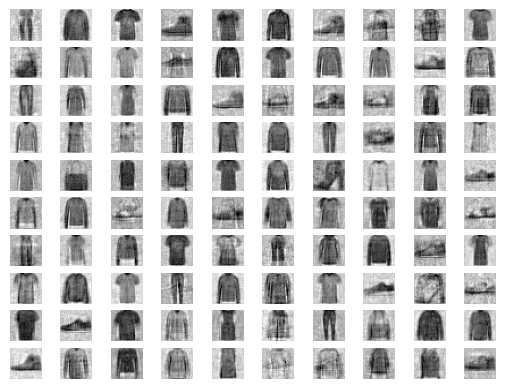

In [16]:
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=20, n_batch=64)

The generated images are not clear which indicates that the current GAN model require further changes and improvements. We may consider adding Convolution layers in our model.